In [1]:
!nvidia-smi

Wed May  8 23:30:28 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 552.22                 Driver Version: 552.22         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050 ...  WDDM  |   00000000:01:00.0  On |                  N/A |
| N/A   69C    P8              8W /   35W |     606MiB /   4096MiB |      6%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
from omegaconf import OmegaConf
import torch
from PIL import Image
from torchvision import transforms
import os
from tqdm import tqdm
from einops import rearrange
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

c:\gotolab\env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
cd c:\gotolab\b4\stable-diffusion

c:\gotolab\b4\stable-diffusion


c:\gotolab\env\Lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [4]:
from ldm.models.diffusion.ddim import DDIMSampler
from ldm.util import instantiate_from_config

In [5]:
cd c:\gotolab\b4

c:\gotolab\b4


In [1]:
import torch
print(torch.cuda.is_available())

print(torch.version.cuda)
print(torch.cuda.get_arch_list())
print(torch.cuda.get_device_capability())

True
12.1
['sm_50', 'sm_60', 'sm_61', 'sm_70', 'sm_75', 'sm_80', 'sm_86', 'sm_90']
(8, 6)


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.ones(1, device=device))

cuda
tensor([1.], device='cuda:0')


In [8]:
# Pytorchを使用して画像生成モデルをロード
from pyexpat import model


def load_model_from_config(config, ckpt, device="cpu", verbose=False):
# MEMO: "config" とはモデルの設定を記したファイルのパス
# MEMO: "ckpt" とは学習済みモデルのチェックポイント(モデルの重みや状態を保存)へのパス
# MEMO: "pl_sd" とは"PyTorch Lightning State Dictionary"の略
    if isinstance(config, (str, Path)): # configがパスの場合
        config = OmegaConf.load(config) 
        
    pl_sd = torch.load(ckpt, map_location="cpu") 
    global_step = pl_sd["global_step"]
    sd = pl_sd["state_dict"]
    model = instantiate_from_config(config.model)
    m, u = model.load_state_dict(sd, strict=False)
    model.to(device) # モデルをCPUに配置
    model.eval() # モデルを推論モード(evaluation)に
    model.cond_stage_model.device = device
    return model

# モデルを使用し画像を生成 
@torch.no_grad()       
def sample_model(model, sampler, c, h, w, ddim_steps, scale, ddim_eta, start_code=None, n_samples=1):
# MEMO: "ddim_steps" とは，ノイズを付与した回数（つまりT）
# MEMO: "ddim_eta" とは，[0,1]の範囲でノイズの強度を表すパラメータ
    uc = None
    if scale != 1.0: # 必要に応じて学習条件を取得
        uc = model.get_learned_conditioning(n_samples * [""])
    
    shape = [4, h // 8, w // 8]
    # 画像を生成
    samples_ddim, _ = sampler.sample(S=ddim_steps,
                                    conditioning=c,
                                    batch_size=n_samples,
                                    shape=shape,
                                    verbose=False,
                                    start_code=start_code,
                                    unconditional_guidance_scale=scale,
                                    unconditional_conditioning=uc,
                                    eta=ddim_eta)
    return samples_ddim

# 画像の前処理
def load_img(path, target_size=512):
    image = Image.open(path).convert("RGB") # PIL形式の画像をRGBに変換
    
    # 画像をテンソルに変換
    t_form = transforms.Compose([
        transforms.Resize(target_size),
        transforms.CenterCrop(target_size),
        transforms.ToTensor(),
    ])
    
    image = t_form(image)
    
    # [-1,1]の範囲に正規化して変換
    return 2. * image -1.

# 生成された画像をデコードしPILに変換
def decode_to_im(samples, n_samples=1, nrow=1):
    samples = model.decode_first_stage(samples)
    ims = torch.clamp((samples + 1.0) / 2.0, min=0.0, max=1.0) #[0,1]の範囲に変換
    x_sample = 255 * rearrange(ims.cpu().numpy(), '(n1 n2) c h w -> (n1 h) (n2 w) c', n1=n_samples//nrow, n2=nrow) #[0,255]の範囲に変換
    
    return Image.fromarray(x_sample.astype(np.uint8))

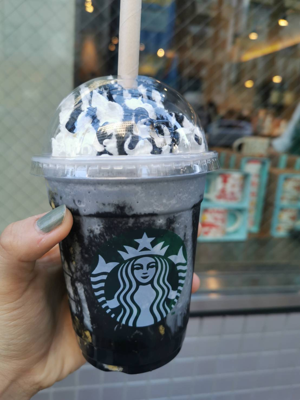

In [15]:
#　モジュールの読み込み
from PIL import Image
#　画像の読み込み 
img_path = r"c:\gotolab\b4\Imagic\pumpkin_pudding_frappuccino.jpg"
img = Image.open(img_path).resize((300, 400))
img

In [9]:
# Setup
device = "cuda:0" # CUDAを使用しGPU(IDが0)上で計算を実行
config = "stable-diffusion/configs/stable-diffusion/v1-inference.yaml"
ckpt = "stable-diffusion/models/ldm/stable-diffusion-v1/sd-v1-4-full-ema.ckpt"
input_img = r"c:\gotolab\b4\Imagic\pumpkin_pudding_frappuccino.jpg" #TODO: 自分で設定
prompt = "A photo of a strawberry frappuccino" #TODO: 自分で設定

# パラメータ
scale = 3
h = 512
w = 512
ddim_steps = 45
ddim_eta = 0.0
torch.manual_seed(0)

model = load_model_from_config(config, ckpt, device)
sampler = DDIMSampler(model)

init_image = load_img(input_img).to(device).unsqueeze(0) # 入力画像を読み込み，デバイスに配置
init_latent = model.get_first_stage_encoding(model.encode_first_stage(init_image)) # 初期画像から初期潜在変数を取得(e_opt)
decode_to_im(init_latent) # 初期潜在変数から画像を生成し表示(e_opt→画像)

orig_emb = model.get_learned_conditioning([prompt]) # テキストプロンプトから潜在変数を取得(e_tgt)
emb = orig_emb.clone()

LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 859.52 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels


c:\gotolab\env\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 46 timesteps


DDIM Sampler: 100%|██████████| 46/46 [08:01<00:00, 10.46s/it]


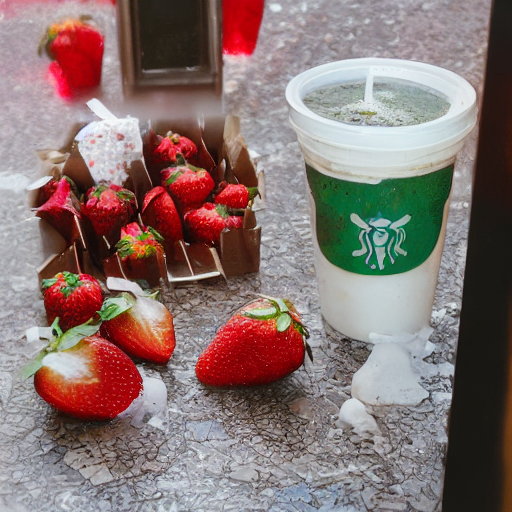

In [10]:
quick_sample = lambda x, s, code: decode_to_im(sample_model(model, sampler, x, h, w, ddim_steps, s, ddim_eta, start_code=code))
start_code = torch.randn_like(init_latent)
quick_sample(emb, scale, start_code)

In [11]:
# Optimize the embedding
emb.requires_grad = True # 埋め込みベクトルの勾配を有効化, e_tgt→e_optを探索
lr = 0.001 # 学習率
it = 500 # 学習のイテレーション数，繰り返し
opt = torch.optim.Adam([emb], lr=lr) # e_tgt→e_optの最適化, 最適化にAdamを使用
criteria = torch.nn.MSELoss() # 平均二乗誤差損失
history = []

pbar = tqdm(range(it)) # 学習の進捗バー
for i in pbar:
    opt.zero_grad() # 初期勾配は0
    
    noise = torch.randn_like(init_latent) # ノイズを生成
    t_enc = torch.randint(1000, (1,), device=device) # これが徐々に更新されてe_optに
    z = model.q_sample(init_latent, t_enc, noise=noise)
    
    pred_noise = model.apply_model(z, t_enc, emb) # 逆拡散過程でノイズを予測
    
    loss = criteria(pred_noise, noise)
    loss.backward() # 損失に対する勾配計算
    pbar.set_postfix({"loss": loss.item()})
    history.append(loss.item()) # パラメータ更新
    opt.step()

100%|██████████| 500/500 [5:02:59<00:00, 36.36s/it, loss=0.16]     


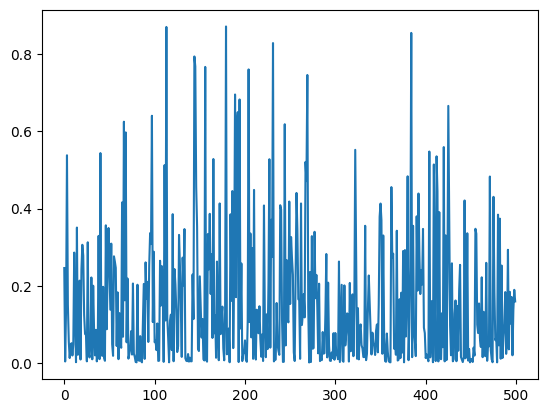

Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 46 timesteps


DDIM Sampler: 100%|██████████| 46/46 [08:01<00:00, 10.46s/it]


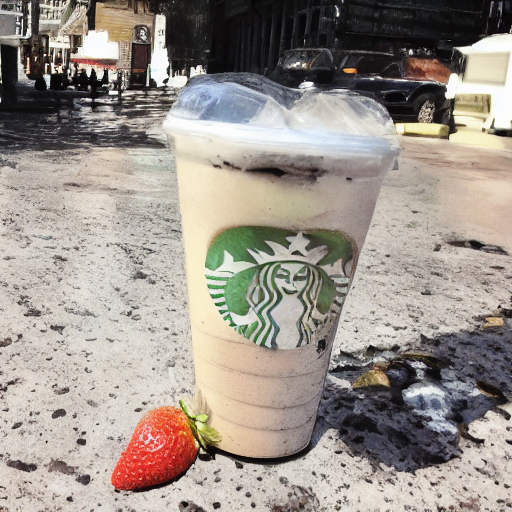

In [12]:
plt.plot(history)
plt.show()
quick_sample(emb, scale, start_code)

In [14]:
# Fine-tune the model
emb.requires_grad = False # 埋め込みベクトルの勾配を無効化, e_optはそのままに，より適合するようにDiffusion Modelを学習させる
model.train()

lr = 1e-6
it = 1000
opt = torch.optim.Adam(model.model.parameters(), lr=lr)
criteria = torch.nn.MSELoss()
history = []

pbar = tqdm(range(it))
for i in pbar:
    opt.zero_grad()
    
    noise = torch.randn_like(init_latent)
    t_enc = torch.randint(model.num_timesteps, (1,), device=device)
    z = model.q_sample(init_latent, t_enc, noise=noise)
    
    pred_noise = model.apply_model(z, t_enc, emb)
    
    loss = criteria(pred_noise, noise)
    loss.backward()
    pbar.set_postfix({"loss": loss.item()})
    history.append(loss.item())
    opt.step()

 14%|█▍        | 145/1000 [1:42:04<10:01:53, 42.24s/it, loss=0.062]  


KeyboardInterrupt: 

In [ ]:
model.eval()
plt.plot(history)
plt.show()
quick_sample(emb, scale, start_code)

In [ ]:
# Generate images
etas = [0.0, 0.25, 0.50, 0.75, 1.0] # TODO: ηの値を設定
for eta in etas:
    new_emb = eta * orig_emb + (1 - eta) * emb
    display(quick_sample(new_emb, scale, start_code))